<a href="https://colab.research.google.com/github/raguram/eva/blob/master/S6/MNIST_Assignment6-withL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install the dependencies


In [46]:
!pip install torchsummary

### Import dependencies

In [0]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm_notebook as tqdm
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
from torch.optim.lr_scheduler import StepLR

### Helper utilities

In [48]:
def isCuda():
  return torch.cuda.is_available()

def randInt(min, max, size): 
  return torch.LongTensor(size).random_(min, max)

def getDevice(): 
  return torch.device("cuda" if isCuda() else "cpu")

def showImages(images, labels, cols=10): 
  figure = plt.figure()
  num_of_images = len(images)
  rows = np.ceil(num_of_images/float(cols))
  for index in range(0, num_of_images):
    plt.subplot(rows, cols, index + 1)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r') 
    plt.title(labels[index].item())

cpu = torch.device("cpu")
device = getDevice()
print(f'\nDevice: {device}')

# Set seed 
seed =1 
torch.manual_seed(seed)
if isCuda():
  torch.cuda.manual_seed(seed)



Device: cuda


### Transformations for Train and Test

In [0]:
def train_transformations(): 
  return transforms.Compose([         
                    transforms.RandomRotation((-7.0, 7.0), fill=(1,)), 
                    transforms.ToTensor(), 
                    transforms.Normalize((0.1307,), (0.3081,))])
  
def test_transformations(): 
  return transforms.Compose([
                    transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

### Load train and test data

In [50]:
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if isCuda() else dict(shuffle=True, batch_size=64)

train_data = datasets.MNIST("../data", train=True, transform=train_transformations(), download=True)
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

test_data = datasets.MNIST("../data", train=False, transform=test_transformations(), download=True)
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

print(f'\nSize of train data:{train_data.data.shape}')
print(f'\nSize of test data:{test_data.data.shape}')


Size of train data:torch.Size([60000, 28, 28])

Size of test data:torch.Size([10000, 28, 28])


### View training/test data and their statistics


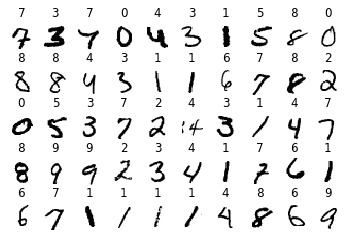

In [51]:
randImages = randInt(0, len(test_data.data), 50)
showImages(test_data.data[randImages], test_data.targets[randImages])

### Network architecture

In [52]:
class Net(nn.Module): 

  def __init__(self): 
    super(Net, self).__init__()

    drop_out = 0.04
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False), # RF - 3x3
        nn.ReLU(), 
        nn.BatchNorm2d(10),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 5x5
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out)
    ) # Output - 24 x 24

    self.transition1 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False), # RF - 5x5
        nn.MaxPool2d(2, 2), # # RF - 6x6
    ) # Output - 12 x 12

    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 10x10
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 14x14
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False), # RF - 18x18
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Dropout2d(drop_out),
        nn.Conv2d(in_channels=16, out_channels=15, kernel_size=(3, 3), padding=0, bias=False), # RF - 22x22
        nn.ReLU()
    ) # output = 4 x 4

    self.gap1 = nn.AdaptiveAvgPool2d(1) # RF - 28x28
    self.conv4 = nn.Conv2d(in_channels=15, out_channels=10, kernel_size=(1, 1), bias=False) # RF - 28x28

  def forward(self, x): 

    x = self.transition1(self.conv1(x))
    x = self.conv2(x)
    x = self.conv4(self.gap1(x))
    x = x.view(-1, 10)
    return F.log_softmax(x)

  def summarize(self, input): 
    summary(self, input_size=input)

Net().to(getDevice()).summarize((1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
              ReLU-2           [-1, 10, 26, 26]               0
       BatchNorm2d-3           [-1, 10, 26, 26]              20
         Dropout2d-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,440
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
         Dropout2d-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32
        Dropout2d-14           [-1, 16,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


### Utilities to compute metrics

In [0]:
def compute_accuracy(prediction, target): 
  return 100 * prediction.eq(target.view_as(prediction)).sum().item() / float(len(prediction))

def compute_miss(data, prediction, target): 
  corrects = prediction.eq(target.view_as(prediction))
  accuracy = corrects.sum().item() / len(prediction)
  miss_indices = ~corrects
  miss_data = data[miss_indices]  
  miss_predictions = prediction[miss_indices]
  miss_targets = target[miss_indices]
  print(confusion_matrix(target.to(cpu), prediction.to(cpu)))
  return (miss_data, miss_predictions, miss_targets)

### Code to train the model

In [0]:
factor = 0.0005

def compute_L1(model): 
  allWeights = torch.cat([x.view(-1) for x in model.parameters()])
  loss = torch.norm(allWeights, 1)
  return loss

def compute_L2(model): 
  allWeights = torch.cat([x.view(-1) for x in model.parameters()])
  loss = torch.norm(allWeights, 2)
  return loss

def train_one_batch(model, data, target, optimizer): 
  optimizer.zero_grad()
  output = model(data)
  loss = F.nll_loss(output, target) + factor * compute_L2(model)
  loss.backward()
  optimizer.step()
  return (loss, output.argmax(dim=1))

def train_one_epoch(model, train_loader, optimizer, device=getDevice()): 
  model.train()
  pbar = tqdm(train_loader, ncols=1000) 
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  for idx, (data, target) in enumerate(pbar): 
    data, target = data.to(device), target.to(device)
    (loss, prediction) = train_one_batch(model, data, target, optimizer)
    accuracy = compute_accuracy(prediction, target)
    wholePred.append(prediction)
    wholeData.append(data)
    wholeTarget.append(target)
    totalLoss += loss
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(train_loader.dataset))

### Code to test the model

In [0]:
def test_one_batch(model, data, target): 
  output = model(data)
  loss = F.nll_loss(output, target)  
  return (loss, output.argmax(dim=1))
  
def test(model, test_loader, device=getDevice()): 
  model.eval()
  pbar = tqdm(test_loader, ncols=1000)
  wholePred = []
  wholeData = []
  wholeTarget = []
  totalLoss = 0
  with torch.no_grad(): 
    for idx, (data, target) in enumerate(pbar): 
      data, target = data.to(device), target.to(device)
      (loss, prediction) = test_one_batch(model, data, target)
      totalLoss += loss
      accuracy = compute_accuracy(prediction, target)
      wholePred.append(prediction)
      wholeData.append(data)
      wholeTarget.append(target)
  return (torch.cat(wholeData), torch.cat(wholeTarget), torch.cat(wholePred), totalLoss/len(test_loader.dataset))

### Build the model by training and testing. 

In [56]:
def build(model, train_loader, optimizer, epoch, scheduler):
  train_accs = []
  train_losses = []
  test_accs = [] 
  test_losses = []
  for e in range(0, epoch): 
    print(f'\n\nEpoch: {e + 1}')
    (train_data, train_target, train_prediction, avgTrainLoss) = train_one_epoch(model, train_loader, optimizer)
    trainAcc = compute_accuracy(train_prediction, train_target)
    train_accs.append(trainAcc)
    train_losses.append(avgTrainLoss)
    print(f'Train Accuracy: {trainAcc}%, Train Loss: {avgTrainLoss}')
    (test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
    testAcc = compute_accuracy(test_prediction, test_target)
    test_accs.append(testAcc)
    test_losses.append(avgTestLoss)
    print(f'Test Accuracy: {testAcc}%, Test Loss: {avgTestLoss}')
    scheduler.step()
  return(train_accs, train_losses, test_accs, test_losses)

net = Net().to(getDevice())
optimizer = optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
(train_accs, train_losses, test_accs, test_losses) = build(net, train_loader, optimizer, 40, scheduler)



Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Accuracy: 83.375%, Train Loss: 0.004133556969463825


Test Accuracy: 97.95%, Test Loss: 0.0005434927879832685


Epoch: 2


Train Accuracy: 97.07833333333333%, Train Loss: 0.0008012301404960454


Test Accuracy: 98.92%, Test Loss: 0.00029040523804724216


Epoch: 3


Train Accuracy: 97.83833333333334%, Train Loss: 0.0006108548259362578


Test Accuracy: 98.85%, Test Loss: 0.0003190547286067158


Epoch: 4


Train Accuracy: 98.13166666666666%, Train Loss: 0.0005140100256539881


Test Accuracy: 99.04%, Test Loss: 0.00023239303845912218


Epoch: 5


Train Accuracy: 98.32666666666667%, Train Loss: 0.00047185132279992104


Test Accuracy: 99.23%, Test Loss: 0.00020402524387463927


Epoch: 6


Train Accuracy: 98.52833333333334%, Train Loss: 0.0004156826762482524


Test Accuracy: 99.27%, Test Loss: 0.00017642468446865678


Epoch: 7


Train Accuracy: 98.63333333333334%, Train Loss: 0.00039962612208910286


Test Accuracy: 99.35%, Test Loss: 0.00018279640062246472


Epoch: 8


Train Accuracy: 98.69166666666666%, Train Loss: 0.0003727733565028757


Test Accuracy: 99.13%, Test Loss: 0.00020006853446830064


Epoch: 9


Train Accuracy: 98.80166666666666%, Train Loss: 0.000360339559847489


Test Accuracy: 99.3%, Test Loss: 0.00016397048602811992


Epoch: 10


Train Accuracy: 98.79166666666667%, Train Loss: 0.0003542304039001465


Test Accuracy: 99.39%, Test Loss: 0.00016630534082651138


Epoch: 11


Train Accuracy: 98.97833333333334%, Train Loss: 0.00030853578937239945


Test Accuracy: 99.48%, Test Loss: 0.00012704869732260704


Epoch: 12


Train Accuracy: 99.035%, Train Loss: 0.00028744988958351314


Test Accuracy: 99.49%, Test Loss: 0.00012595596490427852


Epoch: 13


Train Accuracy: 99.09833333333333%, Train Loss: 0.0002756024186965078


Test Accuracy: 99.51%, Test Loss: 0.00011990247730864212


Epoch: 14


Train Accuracy: 99.115%, Train Loss: 0.00026747077936306596


Test Accuracy: 99.48%, Test Loss: 0.00012094184785382822


Epoch: 15


Train Accuracy: 99.105%, Train Loss: 0.00028275290969759226


Test Accuracy: 99.51%, Test Loss: 0.00012100567255401984


Epoch: 16


Train Accuracy: 99.09166666666667%, Train Loss: 0.0002754432207439095


Test Accuracy: 99.54%, Test Loss: 0.00012119254824938253


Epoch: 17


Train Accuracy: 99.12166666666667%, Train Loss: 0.00027395851793698967


Test Accuracy: 99.51%, Test Loss: 0.00012830244668293744


Epoch: 18


Train Accuracy: 99.09666666666666%, Train Loss: 0.0002758636837825179


Test Accuracy: 99.47%, Test Loss: 0.00011883064144058153


Epoch: 19


Train Accuracy: 99.135%, Train Loss: 0.0002687014057300985


Test Accuracy: 99.48%, Test Loss: 0.0001209139300044626


Epoch: 20


Train Accuracy: 99.135%, Train Loss: 0.00027239450719207525


Test Accuracy: 99.48%, Test Loss: 0.00011890554014826193


Epoch: 21


Train Accuracy: 99.12833333333333%, Train Loss: 0.0002663861960172653


Test Accuracy: 99.48%, Test Loss: 0.00011561779683688655


Epoch: 22


Train Accuracy: 99.16%, Train Loss: 0.0002636740100570023


Test Accuracy: 99.46%, Test Loss: 0.00011865303531521931


Epoch: 23


Train Accuracy: 99.16333333333333%, Train Loss: 0.0002678649907466024


Test Accuracy: 99.46%, Test Loss: 0.00011965286103077233


Epoch: 24


Train Accuracy: 99.19166666666666%, Train Loss: 0.0002576271945144981


Test Accuracy: 99.47%, Test Loss: 0.00011881603859364986


Epoch: 25


Train Accuracy: 99.18833333333333%, Train Loss: 0.0002589593641459942


Test Accuracy: 99.48%, Test Loss: 0.00011755952436942607


Epoch: 26


Train Accuracy: 99.15%, Train Loss: 0.0002644408668857068


Test Accuracy: 99.45%, Test Loss: 0.00011768379044951871


Epoch: 27


Train Accuracy: 99.14%, Train Loss: 0.00025709348847158253


Test Accuracy: 99.48%, Test Loss: 0.00011622461897786707


Epoch: 28


Train Accuracy: 99.15833333333333%, Train Loss: 0.0002644591440912336


Test Accuracy: 99.44%, Test Loss: 0.00011927001469302922


Epoch: 29


Train Accuracy: 99.15333333333334%, Train Loss: 0.00026039566728286445


Test Accuracy: 99.5%, Test Loss: 0.00011710311082424596


Epoch: 30


Train Accuracy: 99.155%, Train Loss: 0.00026609390624798834


Test Accuracy: 99.46%, Test Loss: 0.00011634096881607547


Epoch: 31


Train Accuracy: 99.155%, Train Loss: 0.0002668313682079315


Test Accuracy: 99.5%, Test Loss: 0.00011698596063069999


Epoch: 32


Train Accuracy: 99.16%, Train Loss: 0.000255779130384326


Test Accuracy: 99.48%, Test Loss: 0.00011698558228090405


Epoch: 33


Train Accuracy: 99.15833333333333%, Train Loss: 0.00026275342679582536


Test Accuracy: 99.45%, Test Loss: 0.0001173915370600298


Epoch: 34


Train Accuracy: 99.2%, Train Loss: 0.00025560063659213483


Test Accuracy: 99.46%, Test Loss: 0.00011868876754306257


Epoch: 35


Train Accuracy: 99.19166666666666%, Train Loss: 0.0002549770288169384


Test Accuracy: 99.5%, Test Loss: 0.000119747084681876


Epoch: 36


Train Accuracy: 99.165%, Train Loss: 0.00025851334794424474


Test Accuracy: 99.47%, Test Loss: 0.0001186019871965982


Epoch: 37


Train Accuracy: 99.13666666666667%, Train Loss: 0.00026177652762271464


Test Accuracy: 99.47%, Test Loss: 0.00012102219625376165


Epoch: 38


Train Accuracy: 99.16%, Train Loss: 0.0002548269694671035


Test Accuracy: 99.44%, Test Loss: 0.00011995861132163554


Epoch: 39


Train Accuracy: 99.105%, Train Loss: 0.00026969725149683654


Test Accuracy: 99.47%, Test Loss: 0.00011796097533078864


Epoch: 40


Train Accuracy: 99.21833333333333%, Train Loss: 0.0002549569762777537


Test Accuracy: 99.47%, Test Loss: 0.00011708919919328764


Text(0.5, 1.0, 'Test Loss')

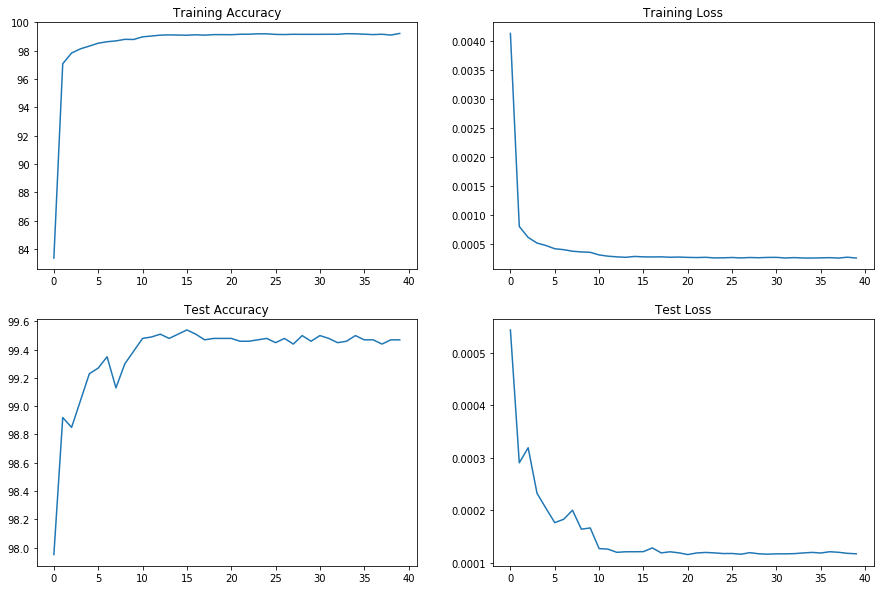

In [57]:
fig, axs = plt.subplots(2,2,figsize=(15, 10))
axs[0, 0].plot(train_accs)
axs[0, 0].set_title("Training Accuracy")
axs[0, 1].plot(train_losses)
axs[0, 1].set_title("Training Loss")
axs[1, 0].plot(test_accs)
axs[1, 0].set_title("Test Accuracy")
axs[1, 1].plot(test_losses)
axs[1, 1].set_title("Test Loss")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:49: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1132    1    1    0    1    0    0    0    0]
 [   1    0 1025    0    1    0    1    4    0    0]
 [   0    0    0 1007    0    2    0    0    1    0]
 [   0    0    0    0  980    0    0    0    0    2]
 [   1    0    0    6    0  882    3    0    0    0]
 [   3    2    0    0    0    1  951    0    1    0]
 [   0    3    4    0    0    0    0 1021    0    0]
 [   0    1    1    1    0    1    0    0  968    2]
 [   1    0    0    0    3    1    0    1    0 1003]]


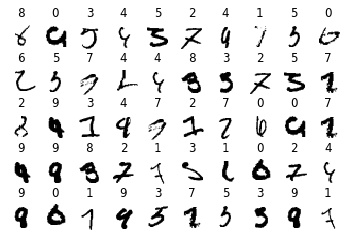

In [58]:
(test_data, test_target, test_prediction, avgTestLoss) = test(net, test_loader)
(miss_data, miss_predictions, miss_targets) = compute_miss(test_data, test_prediction, test_target)

randImages = randInt(0, len(miss_data), 50)
showImages(miss_data[randImages].to(cpu), miss_predictions[randImages].to(cpu))